# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to ipper respiratory tract infection (URTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_admitted',
            event_col='event_urti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    
    # alpha = 0.05
    # #the coefficients of the regression model
    # coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    # #build an auxiliary dataframe with the constant term in it
    # X_aux = data_enc_dev_x.copy()
    # # X_aux.insert(0, 'const', 1)
    # #degrees of freedom
    # dof = -np.diff(X_aux.shape)[0]
    # #Student's t-distribution table lookup
    # t_val = stats.t.isf(alpha/2, dof)
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    # #inverse of the variance of the parameters
    # var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    # #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    # lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    
#     alpha = 0.05
#     #the coefficients of the regression model
#     coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
#     #build an auxiliary dataframe with the constant term in it
#     X_aux = data_enc_dev_x.copy()
#    #  X_aux.insert(0, 'const', 1)
#     #degrees of freedom
#     dof = -np.diff(X_aux.shape)[0]
#     #Student's t-distribution table lookup
#     t_val = stats.t.isf(alpha/2, dof)
#     #MSE of the residuals
#     mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
#     #inverse of the variance of the parameters
#     var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
#     #distance between lower and upper bound of CI
#     gap = t_val * np.sqrt(mse * var_params)
#     lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
#     lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
#     # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
#     lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [10]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [11]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [12]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-05') & (data_urti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

#drop any row with nan in period column
data_urti = data_urti[data_urti['period'].notna()]

In [18]:
data_urti['date'].max()

'2023-05'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti.columns) and (data_urti['smoking'].isnull().sum() > 0):
    data_urti['smoking'] = data_urti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_urti.ethnicity.value_counts('NA')

white      0.599803
unknown    0.248762
other      0.076168
asian      0.075267
Name: ethnicity, dtype: float64

In [31]:
data_urti.smoking.value_counts('NA')

unknown         0.416902
smoker          0.388757
never_smoked    0.128799
ex_smoker       0.065541
Name: smoking_status, dtype: float64

In [32]:
data_urti.bmi_cat.value_counts('NA')

obese             0.519929
unknown           0.254331
overweight        0.112675
healthy_weight    0.081096
underweight       0.031970
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

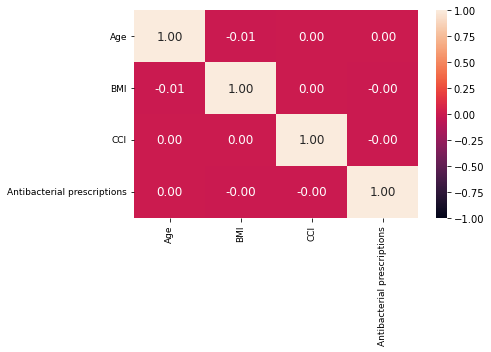

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [36]:
#switch variable urti_ab_date into a binary variable
data_urti[['ab_binary']] = data_urti[['urti_ab_date']].where(data_urti[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['period'] == 'prepandemic']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['period'] == 'during_pandemic')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['period'] == 'post_2nd_lockdown']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['period'] == 'prepandemic']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['period'] == 'during_pandemic')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt_prepandemic = data_urti_incdt_prepandemic[data_urti_incdt_prepandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_during_pandemic = data_urti_incdt_during_pandemic[data_urti_incdt_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_post_2nd_lockdown = data_urti_incdt_post_2nd_lockdown[data_urti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_no_abs_prevl_prepandemic = data_urti_prevl_prepandemic[data_urti_prevl_prepandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_during_pandemic = data_urti_prevl_during_pandemic[data_urti_prevl_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_post_2nd_lockdown = data_urti_prevl_post_2nd_lockdown[data_urti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt)
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 102530 total observations, 101864 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 102530
number of events observed = 666
   partial log-likelihood = -7658.60
         time fit was run = 2023-08-05 08:25:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
CCI_cat[T.medium]                0.19       1.21       0.13            -0.05             0.44                 0.95                 1.55
CCI_cat[T.high]                  0.11       1.11       0.15            -0.19             0.40                 0.83                 1.49
CCI_cat[T.very_high]            -0.07       0.94       0.14            -0.34             0.21                 0.71                 1.23
age_cat[T.25_34]                 0.06       1.07       0.15            -0.23             0.35                 0.80                 1.42
age_cat[T.35_44]                 0.12       1.12       0.15            -0.17             0.40                 0.85                 1.50
age_cat[T.45_54]                -0.04       0.96       0.15            -0.34             0.26                 0.71                 1.29
age_cat[T.55_64]                 0.25       1.28       0.14            -0.03             0.53                 0.97                 1.69
age_cat[T.65_74]                 0.06       1.06       0.15            -0.23             0.35                 0.79                 1.42
age_cat[T.75_more]               0.03       1.03       0.15            -0.26             0.32                 0.77                 1.38
antibacterial_brit               0.00       1.00       0.03            -0.05             0.05                 0.95                 1.06
bmi_cat[T.obese]                 0.38       1.47       0.17             0.05             0.72                 1.05                 2.05
bmi_cat[T.overweight]            0.24       1.27       0.20            -0.16             0.64                 0.85                 1.89
bmi_cat[T.underweight]           0.39       1.47       0.27            -0.14             0.91                 0.87                 2.49
bmi_cat[T.unknown]               0.38       1.46       0.18             0.03             0.73                 1.03                 2.07
ethnicity[T.other]               0.36       1.43       0.20            -0.03             0.75                 0.97                 2.11
ethnicity[T.unknown]             0.01       1.01       0.17            -0.33             0.35                 0.72                 1.42
ethnicity[T.white]               0.18       1.20       0.16            -0.13             0.50                 0.88                 1.65
flu_vaccine[T.yes]              -0.02       0.98       0.13            -0.28             0.24                 0.76                 1.27
imd[T.medium]                   -0.05       0.95       0.13            -0.30             0.19                 0.74                 1.21
imd[T.unaffluent]               -0.10       0.91       0.13            -0.34             0.15                 0.71                 1.16
imd[T.unknown]                   0.27       1.31       0.17            -0.07             0.61                 0.93                 1.84
imd[T.very_affluent]            -0.02       0.98       0.12            -0.26             0.22                 0.77                 1.25
imd[T.very_unaffluent]          -0.12       0.88       0.13            -0.37             0.13                 0.69                 1.13
region[T.east_midlands]         -0.43       0.65       0.19      

13041


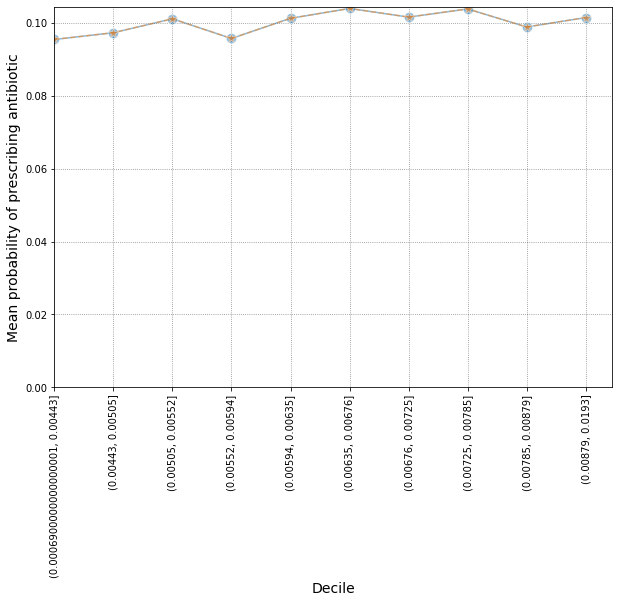


AUROC of LR for deciles with development and validation data: 0.51021 and 0.50360
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00443, 0.00505]  0.021411       -0.062060        0.104881   
1  bins_(0.00505, 0.00552]  0.092790        0.003538        0.182041   
2  bins_(0.00552, 0.00594]  0.003442       -0.081613        0.088497   
3  bins_(0.00594, 0.00635]  0.071334       -0.022548        0.165216   
4  bins_(0.00635, 0.00676]  0.080782        0.001035        0.160529   
5  bins_(0.00676, 0.00725]  0.082518       -0.001838        0.166874   
6  bins_(0.00725, 0.00785]  0.113379        0.028209        0.198549   
7  bins_(0.00785, 0.00879]  0.043015       -0.041017        0.127047   
8   bins_(0.00879, 0.0193]  0.075929       -0.015729        0.167586   

         or  or_lower_95%  or_upper_95%  
0  1.021641      0.939827      1.110578  
1  1.097231      1.003545      1.199663  
2  1.003448      0.921628      1.092531  
3  1.073940    

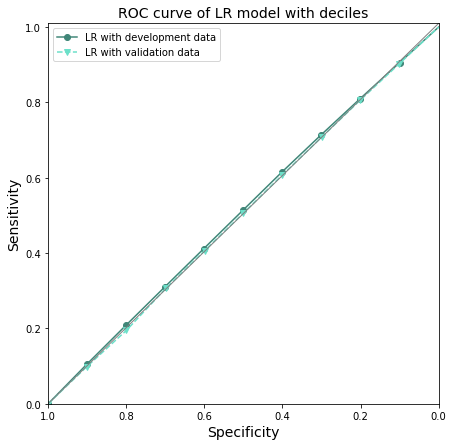

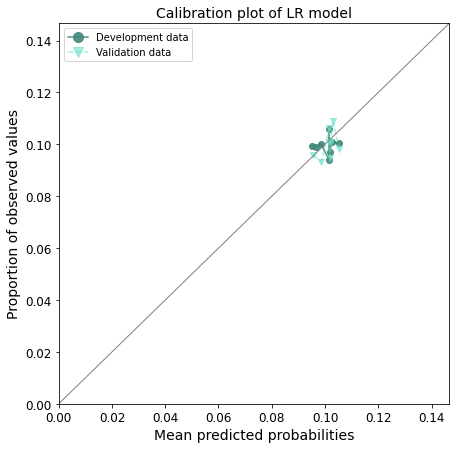


AUROC of LR for risk factors with development and validation data: 0.51779 and 0.49624
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.024237       -0.094444        0.045970   
1                 age_cat_35_44  0.033150       -0.031849        0.098150   
2                 age_cat_45_54 -0.114421       -0.182501       -0.046342   
3                 age_cat_55_64 -0.023780       -0.099732        0.052172   
4                 age_cat_65_74 -0.012179       -0.079001        0.054643   
5               age_cat_75_more -0.006294       -0.067206        0.054618   
6                      sex_male -0.008111       -0.046332        0.030110   
7                  CCI_cat_high  0.030008       -0.038148        0.098164   
8                   CCI_cat_low -0.001334       -0.061996        0.059327   
9                CCI_cat_medium -0.006532       -0.067264        0.054200   
10            CCI_cat_very_high -0.002761       -0.0

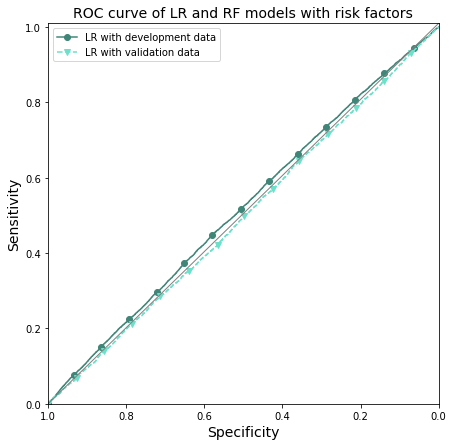

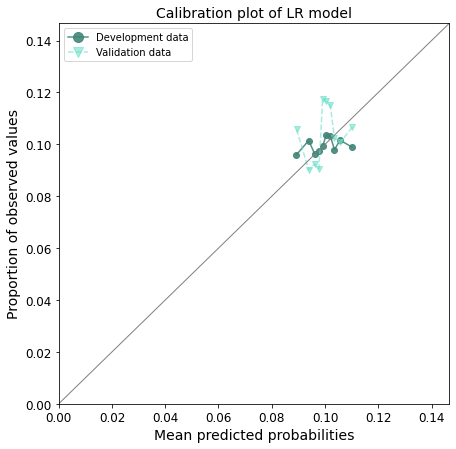

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt, prob_pred_urti_no_abs_incdt_bin = cox_build('urti', 'incdt', data_urti_incdt, data_urti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('urti', 'incdt_deciles', prob_pred_urti_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('urti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('urti', 'incdt', prob_pred_enc_lr_rf_incdt)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('urti', 'incdt_riskfactors', prob_pred_urti_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [41]:
# alpha = 0.05
# #the coefficients of the regression model
# coefs = np.r_[[lr.intercept_], lr.coef_.T.tolist()]
# #build an auxiliary dataframe with the constant term in it
# X_aux = data_enc_dev_incdt_x.copy()
# X_aux.insert(0, 'const', 1)
# #degrees of freedom
# dof = -np.diff(X_aux.shape)[0]
# #Student's t-distribution table lookup
# t_val = stats.t.isf(alpha/2, dof)
# #MSE of the residuals
# mse = np.sum((data_enc_dev_incdt_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_incdt_x)) ** 2) / dof
# #inverse of the variance of the parameters
# var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
# #distance between lower and upper bound of CI
# gap = t_val * np.sqrt(mse * var_params)
# coef_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap})
# coef_ints

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11251 total observations, 11178 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11251
number of events observed = 73
   partial log-likelihood = -665.12
         time fit was run = 2023-08-05 08:28:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.39            -0.44             1.08                 0.65                 2.95
CCI_cat[T.medium]                0.21       1.23       0.43            -0.63             1.05                 0.53                 2.84
CCI_cat[T.high]                  0.53       1.69       0.46            -0.38             1.43                 0.69                 4.18
CCI_cat[T.very_high]             0.48       1.62       0.43            -0.36             1.32                 0.70                 3.74
age_cat[T.25_34]                -0.02       0.98       0.39            -0.79             0.75                 0.45                 2.11
age_cat[T.35_44]                -0.20       0.82       0.41            -1.01             0.60                 0.37                 1.83
age_cat[T.45_54]                -0.54       0.58       0.45            -1.42             0.34                 0.24                 1.40
age_cat[T.55_64]                -0.05       0.95       0.39            -0.82             0.72                 0.44                 2.05
age_cat[T.65_74]                -0.41       0.66       0.43            -1.26             0.44                 0.28                 1.55
age_cat[T.75_more]              -0.81       0.44       0.49            -1.78             0.16                 0.17                 1.17
antibacterial_brit               0.08       1.08       0.08            -0.08             0.24                 0.93                 1.27
bmi_cat[T.obese]                 1.23       3.41       0.72            -0.19             2.65                 0.83                14.12
bmi_cat[T.overweight]            1.09       2.96       0.79            -0.47             2.64                 0.63                13.97
bmi_cat[T.underweight]           1.03       2.80       1.00            -0.93             2.99                 0.39                19.96
bmi_cat[T.unknown]               1.15       3.16       0.74            -0.31             2.61                 0.73                13.57
ethnicity[T.other]               0.49       1.63       0.57            -0.63             1.61                 0.53                 5.00
ethnicity[T.unknown]            -0.16       0.85       0.52            -1.19             0.86                 0.30                 2.36
ethnicity[T.white]               0.19       1.21       0.47            -0.73             1.12                 0.48                 3.06
flu_vaccine[T.yes]              -0.49       0.61       0.46            -1.40             0.42                 0.25                 1.52
imd[T.medium]                    0.54       1.71       0.39            -0.24             1.31                 0.79                 3.71
imd[T.unaffluent]                0.47       1.59       0.40            -0.33             1.26                 0.72                 3.52
imd[T.unknown]                   0.68       1.97       0.55            -0.40             1.76                 0.67                 5.79
imd[T.very_affluent]            -0.05       0.96       0.45            -0.92             0.83                 0.40                 2.30
imd[T.very_unaffluent]           0.30       1.35       0.41            -0.51             1.11                 0.60                 3.04
region[T.east_midlands]          0.01       1.01       0.56           

13038


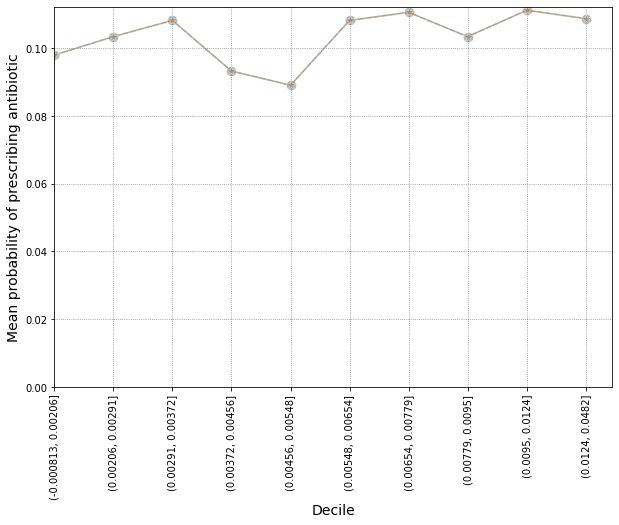


AUROC of LR for deciles with development and validation data: 0.51882 and 0.52224
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00206, 0.00291] -0.035562       -0.277880        0.206757   
1  bins_(0.00291, 0.00372]  0.010858       -0.191304        0.213020   
2  bins_(0.00372, 0.00456] -0.049784       -0.302732        0.203165   
3  bins_(0.00456, 0.00548] -0.183519       -0.420938        0.053901   
4  bins_(0.00548, 0.00654]  0.045890       -0.179271        0.271051   
5  bins_(0.00654, 0.00779] -0.008850       -0.237066        0.219367   
6   bins_(0.00779, 0.0095] -0.011170       -0.218740        0.196400   
7    bins_(0.0095, 0.0124]  0.079701       -0.143260        0.302662   
8    bins_(0.0124, 0.0482]  0.084935       -0.116253        0.286122   

         or  or_lower_95%  or_upper_95%  
0  0.965063      0.757387      1.229684  
1  1.010917      0.825882      1.237410  
2  0.951435      0.738797      1.225275  
3  0.832336    

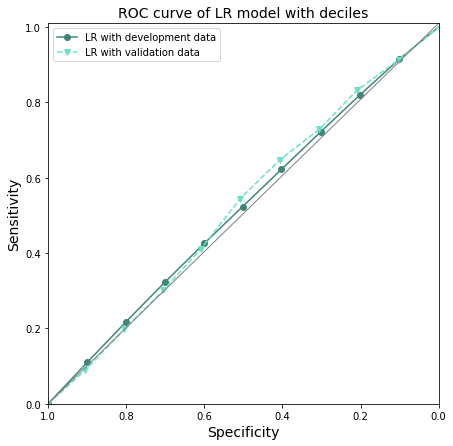

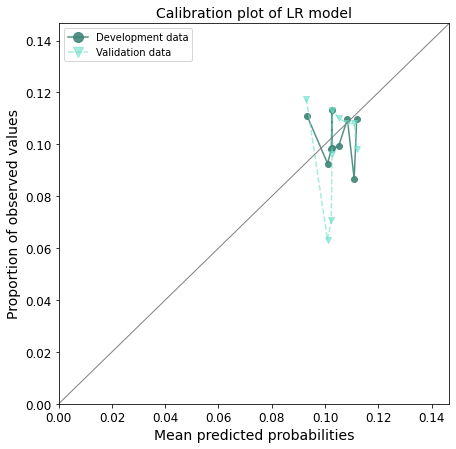


AUROC of LR for risk factors with development and validation data: 0.55183 and 0.49861
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.076870       -0.304121        0.150380   
1                 age_cat_35_44  0.017356       -0.186422        0.221135   
2                 age_cat_45_54 -0.016147       -0.245733        0.213439   
3                 age_cat_55_64  0.075661       -0.141869        0.293190   
4                 age_cat_65_74 -0.000331       -0.225216        0.224554   
5               age_cat_75_more  0.024046       -0.190591        0.238682   
6                      sex_male  0.090118       -0.006712        0.186947   
7                  CCI_cat_high  0.019169       -0.168234        0.206573   
8                   CCI_cat_low  0.051410       -0.108713        0.211533   
9                CCI_cat_medium  0.097895       -0.073669        0.269460   
10            CCI_cat_very_high  0.007409       -0.1

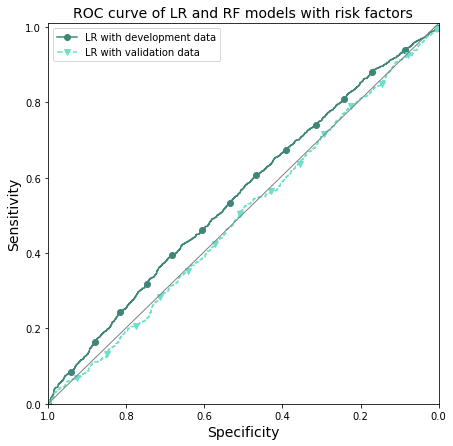

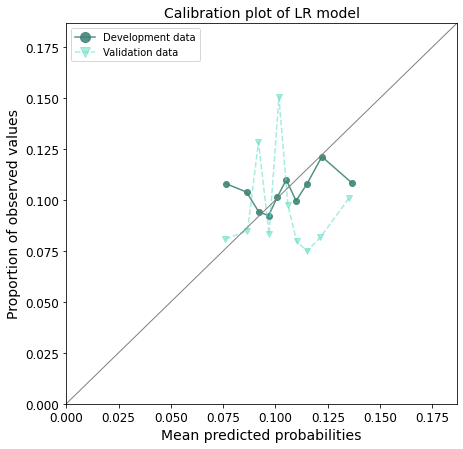

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl, prob_pred_urti_no_abs_prevl_bin = cox_build('urti', 'prevl', data_urti_prevl, data_urti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('urti', 'prevl_deciles', prob_pred_urti_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('urti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('urti', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('urti', 'prevl_riskfactors', prob_pred_urti_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28511 total observations, 28345 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 28511
number of events observed = 166
   partial log-likelihood = -1681.36
         time fit was run = 2023-08-05 08:29:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.23            -0.49             0.40                 0.61                 1.50
CCI_cat[T.medium]               -0.09       0.91       0.26            -0.59             0.41                 0.55                 1.50
CCI_cat[T.high]                 -0.31       0.73       0.33            -0.95             0.33                 0.39                 1.39
CCI_cat[T.very_high]            -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.67
age_cat[T.25_34]                -0.02       0.98       0.28            -0.57             0.52                 0.57                 1.68
age_cat[T.35_44]                -0.17       0.85       0.29            -0.73             0.40                 0.48                 1.49
age_cat[T.45_54]                -0.76       0.47       0.34            -1.43            -0.09                 0.24                 0.91
age_cat[T.55_64]                -0.01       0.99       0.28            -0.55             0.54                 0.58                 1.71
age_cat[T.65_74]                -0.16       0.85       0.29            -0.72             0.40                 0.49                 1.49
age_cat[T.75_more]               0.11       1.11       0.27            -0.42             0.64                 0.66                 1.89
antibacterial_brit               0.04       1.04       0.05            -0.07             0.14                 0.94                 1.16
bmi_cat[T.obese]                -0.11       0.90       0.28            -0.66             0.44                 0.52                 1.55
bmi_cat[T.overweight]            0.27       1.31       0.32            -0.36             0.90                 0.70                 2.46
bmi_cat[T.underweight]           0.35       1.42       0.44            -0.51             1.21                 0.60                 3.34
bmi_cat[T.unknown]              -0.43       0.65       0.32            -1.05             0.19                 0.35                 1.20
ethnicity[T.other]               0.72       2.04       0.40            -0.08             1.51                 0.92                 4.52
ethnicity[T.unknown]             0.19       1.20       0.37            -0.54             0.92                 0.58                 2.50
ethnicity[T.white]               0.35       1.42       0.35            -0.33             1.04                 0.72                 2.82
flu_vaccine[T.yes]               0.17       1.19       0.24            -0.31             0.65                 0.74                 1.92
imd[T.medium]                   -0.05       0.96       0.25            -0.54             0.45                 0.58                 1.57
imd[T.unaffluent]                0.23       1.26       0.24            -0.24             0.70                 0.79                 2.01
imd[T.unknown]                   0.32       1.38       0.35            -0.36             1.01                 0.70                 2.74
imd[T.very_affluent]            -0.09       0.91       0.26            -0.60             0.41                 0.55                 1.51
imd[T.very_unaffluent]          -0.27       0.77       0.27            -0.79             0.26                 0.45                 1.29
region[T.east_midlands]         -0.02       0.98       0.34         

13051


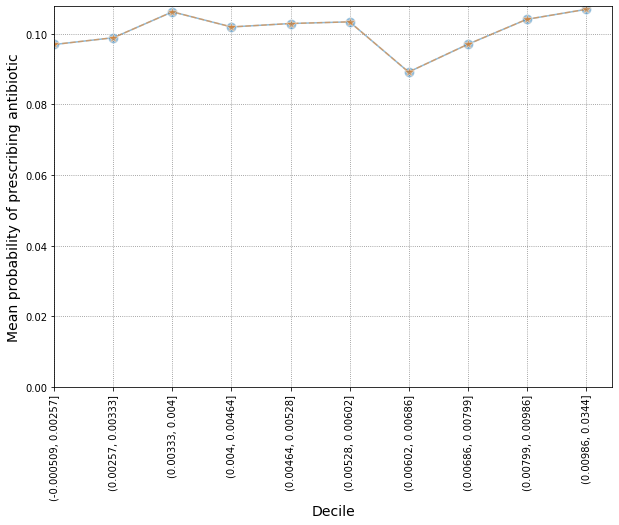


AUROC of LR for deciles with development and validation data: 0.51726 and 0.50580
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00257, 0.00333]  0.062899       -0.093265        0.219063   
1    bins_(0.00333, 0.004]  0.148355       -0.015580        0.312290   
2    bins_(0.004, 0.00464]  0.079009       -0.064171        0.222188   
3  bins_(0.00464, 0.00528]  0.044228       -0.121474        0.209930   
4  bins_(0.00528, 0.00602]  0.114303       -0.042778        0.271384   
5  bins_(0.00602, 0.00686] -0.049532       -0.225471        0.126407   
6  bins_(0.00686, 0.00799]  0.039288       -0.137851        0.216426   
7  bins_(0.00799, 0.00986]  0.082614       -0.085886        0.251115   
8   bins_(0.00986, 0.0344]  0.163902        0.000739        0.327065   

         or  or_lower_95%  or_upper_95%  
0  1.064919      0.910952      1.244909  
1  1.159925      0.984540      1.366552  
2  1.082214      0.937845      1.248806  
3  1.045220    

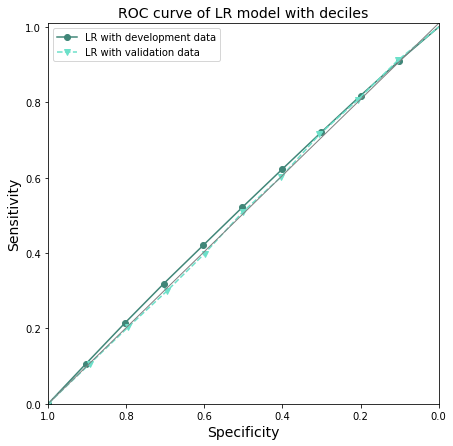

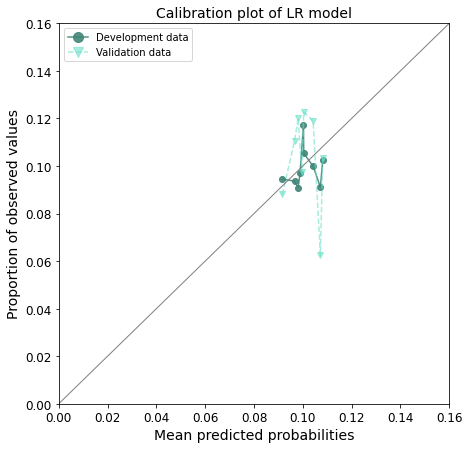

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_prepandemic, prob_pred_urti_no_abs_incdt_prepandemic_bin = cox_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic, data_urti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti', 'incdt_prepandemic_deciles', prob_pred_urti_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26131 total observations, 25957 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 26131
number of events observed = 174
   partial log-likelihood = -1752.89
         time fit was run = 2023-08-05 08:29:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.21            -0.64             0.17                 0.53                 1.19
CCI_cat[T.medium]               -0.33       0.72       0.24            -0.80             0.14                 0.45                 1.15
CCI_cat[T.high]                 -0.31       0.73       0.29            -0.89             0.26                 0.41                 1.30
CCI_cat[T.very_high]            -0.51       0.60       0.27            -1.03             0.01                 0.36                 1.01
age_cat[T.25_34]                 0.05       1.05       0.28            -0.50             0.60                 0.60                 1.81
age_cat[T.35_44]                -0.01       0.99       0.28            -0.56             0.55                 0.57                 1.73
age_cat[T.45_54]                 0.03       1.03       0.28            -0.51             0.58                 0.60                 1.78
age_cat[T.55_64]                 0.03       1.03       0.28            -0.52             0.59                 0.59                 1.80
age_cat[T.65_74]                -0.02       0.98       0.29            -0.58             0.54                 0.56                 1.72
age_cat[T.75_more]              -0.14       0.87       0.29            -0.71             0.44                 0.49                 1.55
antibacterial_brit               0.00       1.00       0.05            -0.10             0.11                 0.91                 1.11
bmi_cat[T.obese]                 0.13       1.13       0.30            -0.45             0.71                 0.64                 2.03
bmi_cat[T.overweight]            0.22       1.25       0.35            -0.46             0.90                 0.63                 2.47
bmi_cat[T.underweight]           0.00       1.00       0.53            -1.03             1.03                 0.36                 2.81
bmi_cat[T.unknown]              -0.05       0.96       0.32            -0.67             0.58                 0.51                 1.79
ethnicity[T.other]              -0.26       0.77       0.40            -1.05             0.53                 0.35                 1.70
ethnicity[T.unknown]            -0.18       0.83       0.31            -0.79             0.42                 0.45                 1.53
ethnicity[T.white]              -0.06       0.94       0.28            -0.61             0.50                 0.54                 1.65
flu_vaccine[T.yes]               0.08       1.08       0.25            -0.41             0.57                 0.66                 1.76
imd[T.medium]                   -0.15       0.86       0.26            -0.66             0.37                 0.52                 1.45
imd[T.unaffluent]               -0.13       0.87       0.26            -0.65             0.38                 0.52                 1.47
imd[T.unknown]                   0.06       1.06       0.40            -0.72             0.84                 0.49                 2.31
imd[T.very_affluent]             0.29       1.34       0.24            -0.18             0.75                 0.84                 2.13
imd[T.very_unaffluent]           0.24       1.27       0.24            -0.23             0.71                 0.79                 2.04
region[T.east_midlands]         -0.40       0.67       0.43         

13044


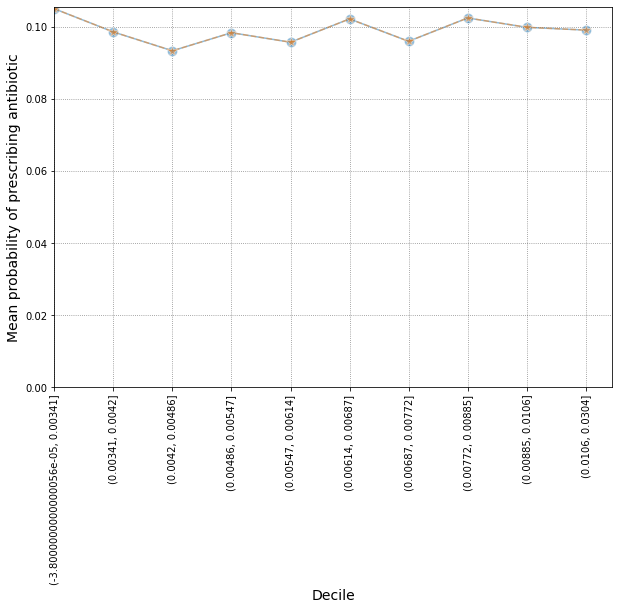


AUROC of LR for deciles with development and validation data: 0.51081 and 0.50168
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00341, 0.0042] -0.030273       -0.195929        0.135382   
1   bins_(0.0042, 0.00486] -0.083435       -0.249735        0.082865   
2  bins_(0.00486, 0.00547] -0.092394       -0.257472        0.072684   
3  bins_(0.00547, 0.00614] -0.075350       -0.251970        0.101270   
4  bins_(0.00614, 0.00687] -0.010143       -0.169809        0.149524   
5  bins_(0.00687, 0.00772] -0.103460       -0.253136        0.046216   
6  bins_(0.00772, 0.00885] -0.034950       -0.187951        0.118051   
7   bins_(0.00885, 0.0106] -0.021160       -0.180245        0.137925   
8    bins_(0.0106, 0.0304] -0.060583       -0.230550        0.109384   

         or  or_lower_95%  or_upper_95%  
0  0.970180      0.822071      1.144974  
1  0.919951      0.779007      1.086396  
2  0.911746      0.773003      1.075391  
3  0.927419    

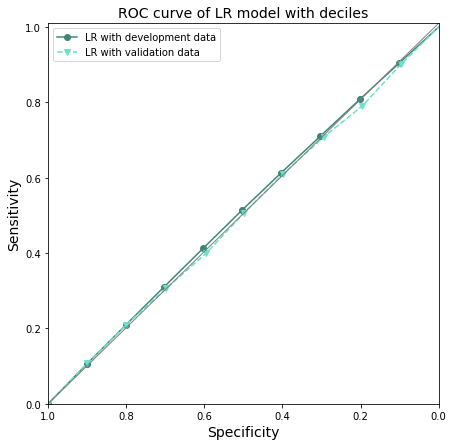

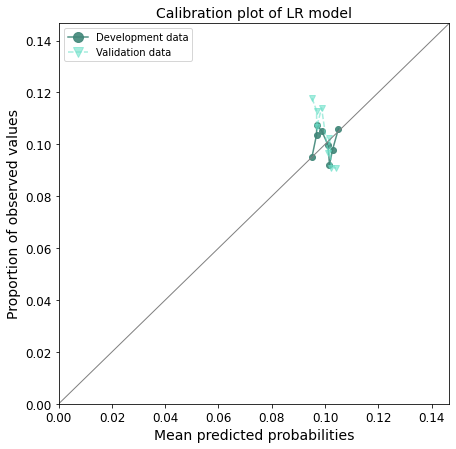

In [44]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_during_pandemic, prob_pred_urti_no_abs_incdt_during_pandemic_bin = cox_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic, data_urti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti', 'incdt_during_pandemic_deciles', prob_pred_urti_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 47887 total observations, 47548 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 47887
number of events observed = 339
   partial log-likelihood = -3630.01
         time fit was run = 2023-08-05 08:29:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.16            -0.31             0.34                 0.74                 1.40
CCI_cat[T.medium]                0.22       1.25       0.17            -0.12             0.56                 0.88                 1.75
CCI_cat[T.high]                  0.09       1.09       0.21            -0.32             0.50                 0.72                 1.65
CCI_cat[T.very_high]            -0.19       0.82       0.20            -0.59             0.20                 0.56                 1.22
age_cat[T.25_34]                -0.27       0.77       0.22            -0.70             0.17                 0.50                 1.18
age_cat[T.35_44]                 0.04       1.04       0.20            -0.36             0.44                 0.70                 1.56
age_cat[T.45_54]                -0.23       0.80       0.22            -0.66             0.20                 0.52                 1.22
age_cat[T.55_64]                 0.20       1.22       0.20            -0.19             0.58                 0.83                 1.79
age_cat[T.65_74]                 0.28       1.32       0.19            -0.10             0.66                 0.90                 1.93
age_cat[T.75_more]               0.08       1.08       0.20            -0.32             0.48                 0.73                 1.61
antibacterial_brit              -0.02       0.99       0.04            -0.09             0.06                 0.91                 1.06
bmi_cat[T.obese]                 0.07       1.07       0.21            -0.34             0.48                 0.71                 1.62
bmi_cat[T.overweight]           -0.29       0.75       0.27            -0.83             0.25                 0.44                 1.29
bmi_cat[T.underweight]          -0.12       0.88       0.39            -0.88             0.63                 0.41                 1.88
bmi_cat[T.unknown]               0.18       1.19       0.22            -0.26             0.61                 0.77                 1.84
ethnicity[T.other]              -0.01       0.99       0.27            -0.55             0.53                 0.58                 1.70
ethnicity[T.unknown]            -0.10       0.91       0.23            -0.54             0.35                 0.58                 1.42
ethnicity[T.white]              -0.02       0.98       0.21            -0.43             0.39                 0.65                 1.47
flu_vaccine[T.yes]              -0.43       0.65       0.22            -0.85            -0.01                 0.43                 0.99
imd[T.medium]                   -0.01       0.99       0.17            -0.34             0.31                 0.71                 1.37
imd[T.unaffluent]               -0.21       0.81       0.17            -0.56             0.13                 0.57                 1.14
imd[T.unknown]                  -0.02       0.98       0.26            -0.53             0.48                 0.59                 1.62
imd[T.very_affluent]            -0.08       0.93       0.17            -0.41             0.26                 0.66                 1.29
imd[T.very_unaffluent]          -0.36       0.70       0.18            -0.72             0.00                 0.49                 1.00
region[T.east_midlands]         -0.43       0.65       0.25         

13057


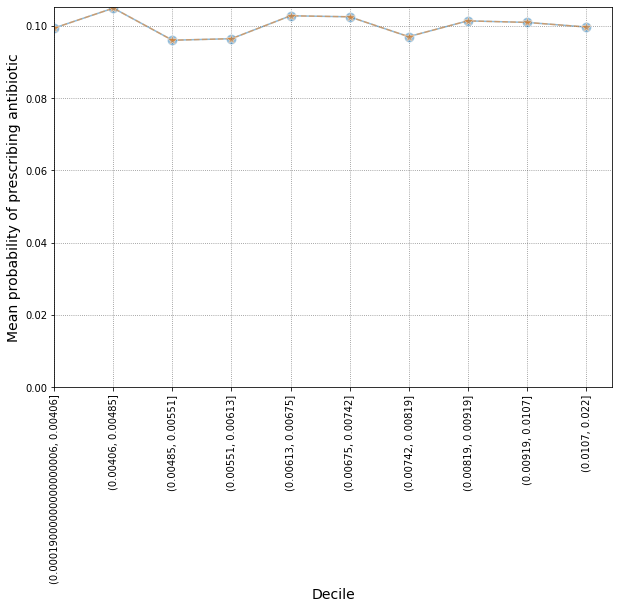


AUROC of LR for deciles with development and validation data: 0.50964 and 0.50023
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00406, 0.00485]  0.091241       -0.031866        0.214348   
1  bins_(0.00485, 0.00551]  0.012419       -0.124636        0.149473   
2  bins_(0.00551, 0.00613]  0.031883       -0.085793        0.149560   
3  bins_(0.00613, 0.00675]  0.105036       -0.019413        0.229485   
4  bins_(0.00675, 0.00742]  0.067098       -0.057700        0.191897   
5  bins_(0.00742, 0.00819]  0.039808       -0.081033        0.160649   
6  bins_(0.00819, 0.00919]  0.074627       -0.064974        0.214228   
7   bins_(0.00919, 0.0107]  0.054243       -0.064117        0.172603   
8     bins_(0.0107, 0.022]  0.042190       -0.097046        0.181426   

         or  or_lower_95%  or_upper_95%  
0  1.095533      0.968637      1.239054  
1  1.012496      0.882819      1.161222  
2  1.032397      0.917784      1.161323  
3  1.110751    

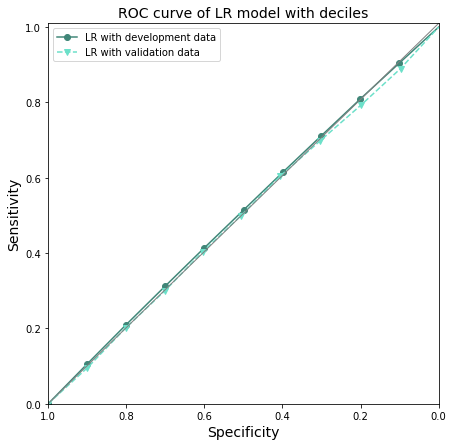

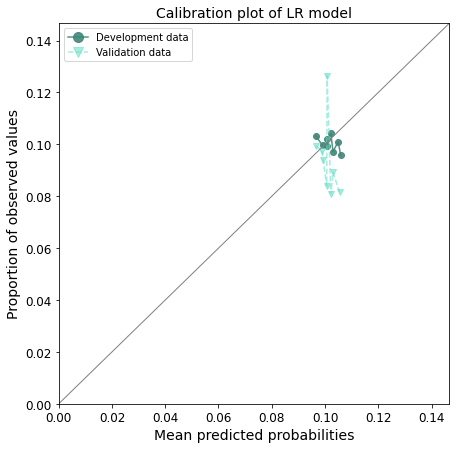

In [45]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown, data_urti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3101 total observations, 3086 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3101
number of events observed = 15
   partial log-likelihood = -92.27
         time fit was run = 2023-08-05 08:30:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.56       1.75       0.85            -1.10             2.22                 0.33                 9.17
CCI_cat[T.medium]               -0.57       0.57       1.06            -2.64             1.50                 0.07                 4.50
CCI_cat[T.high]                 -0.38       0.68       1.29            -2.91             2.15                 0.05                 8.57
CCI_cat[T.very_high]             0.61       1.84       0.95            -1.26             2.48                 0.28                11.96
age_cat[T.25_34]                 1.52       4.56       1.20            -0.83             3.87                 0.44                47.72
age_cat[T.35_44]                 1.57       4.81       1.14            -0.67             3.81                 0.51                45.19
age_cat[T.45_54]                 1.55       4.73       1.18            -0.77             3.88                 0.46                48.29
age_cat[T.55_64]                 0.05       1.05       1.44            -2.78             2.87                 0.06                17.70
age_cat[T.65_74]                 0.97       2.64       1.18            -1.34             3.28                 0.26                26.51
age_cat[T.75_more]             -17.32       0.00    5509.13        -10815.01         10780.37                 0.00                  inf
antibacterial_brit               0.18       1.20       0.18            -0.18             0.54                 0.84                 1.72
bmi_cat[T.obese]                20.25   6.26e+08   22983.42        -45026.42         45066.93                 0.00                  inf
bmi_cat[T.overweight]           19.74   3.76e+08   22983.42        -45026.93         45066.42                 0.00                  inf
bmi_cat[T.underweight]          22.48   5.79e+09   22983.42        -45024.19         45069.15                 0.00                  inf
bmi_cat[T.unknown]              20.48   7.84e+08   22983.42        -45026.19         45067.15                 0.00                  inf
ethnicity[T.other]              18.64   1.25e+08    6988.88        -13679.31         13716.59                 0.00                  inf
ethnicity[T.unknown]            18.08   7.11e+07    6988.88        -13679.87         13716.03                 0.00                  inf
ethnicity[T.white]              18.06   6.96e+07    6988.88        -13679.89         13716.01                 0.00                  inf
flu_vaccine[T.yes]              -0.69       0.50       1.08            -2.81             1.43                 0.06                 4.19
imd[T.medium]                    1.61       5.03       1.12            -0.58             3.81                 0.56                45.32
imd[T.unaffluent]                1.24       3.46       1.13            -0.98             3.46                 0.38                31.82
imd[T.unknown]                 -18.10       0.00   10978.26        -21535.10         21498.90                 0.00                  inf
imd[T.very_affluent]             0.67       1.96       1.25            -1.77             3.12                 0.17                22.65
imd[T.very_unaffluent]           0.63       1.88       1.19            -1.70             2.97                 0.18                19.52
region[T.east_midlands]         18.82   1.49e+08    8821.92        -17271.

13357


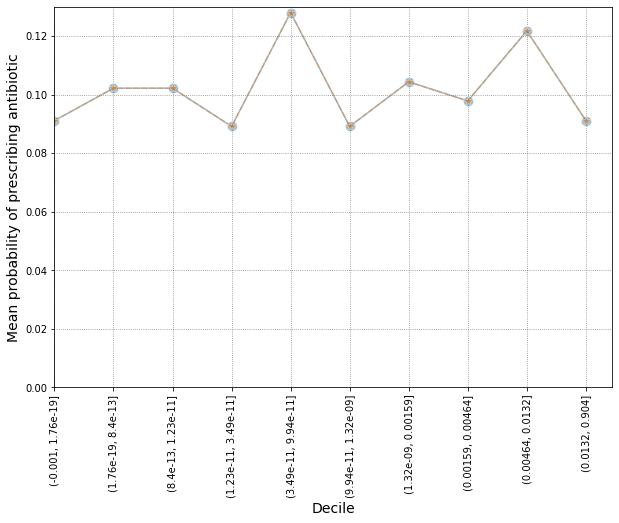


AUROC of LR for deciles with development and validation data: 0.53924 and 0.47079
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00159, 0.00464] -0.114874       -0.541037        0.311290   
1     bins_(0.00464, 0.0132]  0.193948       -0.191120        0.579015   
2       bins_(0.0132, 0.904] -0.070684       -0.424902        0.283535   
3  bins_(1.23e-11, 3.49e-11] -0.062303       -0.474918        0.350311   
4   bins_(1.32e-09, 0.00159] -0.120707       -0.546631        0.305217   
5   bins_(1.76e-19, 8.4e-13]  0.061497       -0.354404        0.477397   
6  bins_(3.49e-11, 9.94e-11]  0.247814       -0.180053        0.675680   
7   bins_(8.4e-13, 1.23e-11] -0.159047       -0.594950        0.276856   
8  bins_(9.94e-11, 1.32e-09] -0.186901       -0.621698        0.247897   

         or  or_lower_95%  or_upper_95%  
0  0.891479      0.582144      1.365185  
1  1.214033      0.826034      1.784281  
2  0.931757      0.653834      1.3278

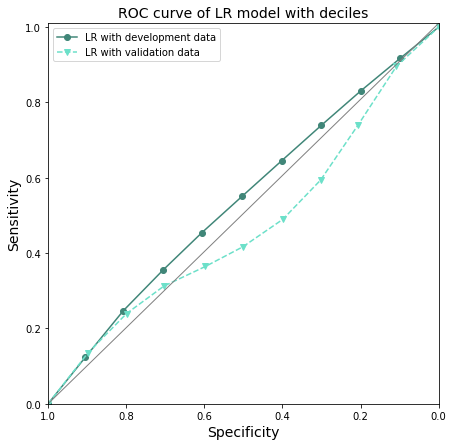

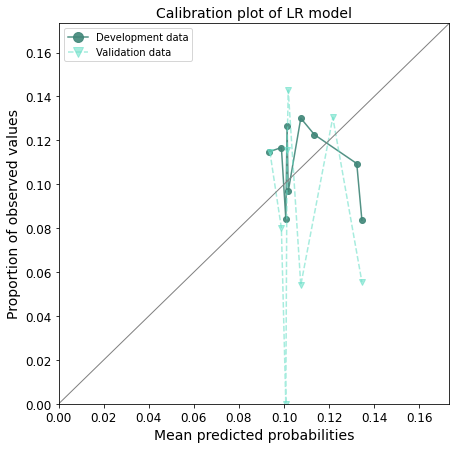

In [46]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_prepandemic, prob_pred_urti_no_abs_prevl_prepandemic_bin = cox_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic, data_urti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti', 'prevl_prepandemic_deciles', prob_pred_urti_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2906 total observations, 2894 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2906
number of events observed = 12
   partial log-likelihood = -81.35
         time fit was run = 2023-08-05 08:30:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.51       0.60       0.93            -2.33             1.31                 0.10                 3.69
CCI_cat[T.medium]               -0.34       0.71       1.02            -2.33             1.66                 0.10                 5.25
CCI_cat[T.high]                  0.56       1.75       1.02            -1.44             2.56                 0.24                12.95
CCI_cat[T.very_high]             0.37       1.44       0.93            -1.45             2.19                 0.23                 8.90
age_cat[T.25_34]               -18.28       0.00    6084.23        -11943.16         11906.60                 0.00                  inf
age_cat[T.35_44]                 0.36       1.43       0.94            -1.48             2.19                 0.23                 8.94
age_cat[T.45_54]                -0.89       0.41       1.25            -3.33             1.55                 0.04                 4.71
age_cat[T.55_64]                -0.02       0.98       1.03            -2.05             2.00                 0.13                 7.41
age_cat[T.65_74]                -0.81       0.45       1.24            -3.24             1.62                 0.04                 5.07
age_cat[T.75_more]               0.29       1.34       0.93            -1.53             2.11                 0.22                 8.27
antibacterial_brit              -0.00       1.00       0.21            -0.42             0.42                 0.66                 1.52
bmi_cat[T.obese]                -0.14       0.87       1.13            -2.35             2.07                 0.10                 7.90
bmi_cat[T.overweight]            0.89       2.44       1.20            -1.45             3.24                 0.23                25.56
bmi_cat[T.underweight]           1.11       3.02       1.48            -1.79             4.00                 0.17                54.87
bmi_cat[T.unknown]              -0.55       0.58       1.25            -3.01             1.91                 0.05                 6.76
ethnicity[T.other]              18.11   7.33e+07    7776.51        -15223.58         15259.80                 0.00                  inf
ethnicity[T.unknown]            18.30   8.83e+07    7776.51        -15223.39         15259.99                 0.00                  inf
ethnicity[T.white]              17.81   5.44e+07    7776.51        -15223.88         15259.50                 0.00                  inf
flu_vaccine[T.yes]              -0.35       0.71       1.07            -2.44             1.74                 0.09                 5.71
imd[T.medium]                   -0.37       0.69       0.78            -1.90             1.16                 0.15                 3.20
imd[T.unaffluent]               -0.99       0.37       0.90            -2.75             0.76                 0.06                 2.14
imd[T.unknown]                 -18.58       0.00    9995.80        -19609.99         19572.83                 0.00                  inf
imd[T.very_affluent]            -0.64       0.53       0.89            -2.38             1.10                 0.09                 3.01
imd[T.very_unaffluent]          -1.63       0.20       1.14            -3.85             0.60                 0.02                 1.82
region[T.east_midlands]        -18.55       0.00    7171.65        -14074.

13162


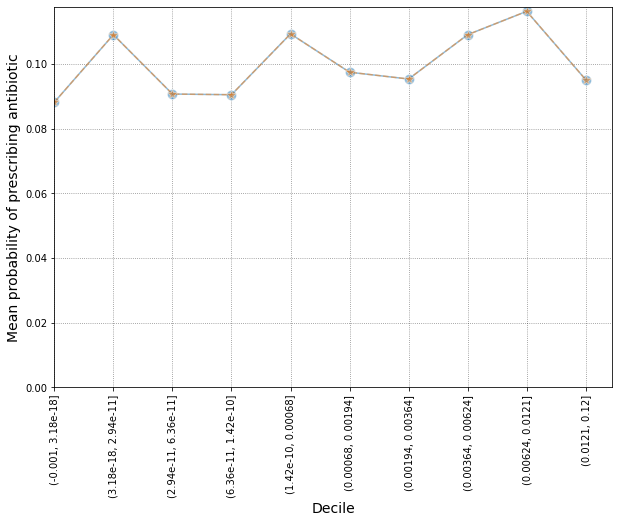


AUROC of LR for deciles with development and validation data: 0.54609 and 0.48292
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00068, 0.00194]  0.027390       -0.423810        0.478590   
1    bins_(0.00194, 0.00364] -0.007331       -0.483568        0.468905   
2    bins_(0.00364, 0.00624]  0.147570       -0.288112        0.583252   
3     bins_(0.00624, 0.0121]  0.343275       -0.087536        0.774085   
4        bins_(0.0121, 0.12]  0.047254       -0.413412        0.507920   
5   bins_(1.42e-10, 0.00068]  0.220521       -0.190180        0.631222   
6  bins_(2.94e-11, 6.36e-11] -0.112061       -0.578564        0.354442   
7  bins_(3.18e-18, 2.94e-11]  0.283557       -0.135260        0.702375   
8  bins_(6.36e-11, 1.42e-10] -0.203125       -0.647428        0.241177   

         or  or_lower_95%  or_upper_95%  
0  1.027769      0.654548      1.613797  
1  0.992696      0.616580      1.598243  
2  1.159015      0.749678      1.7918

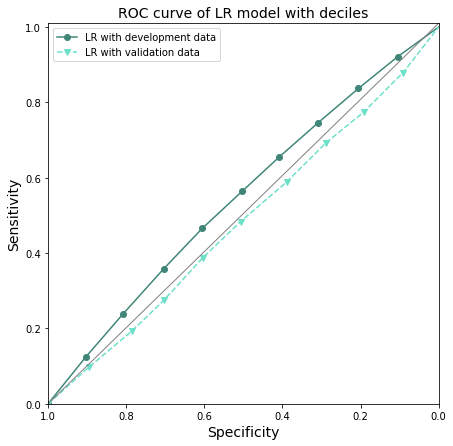

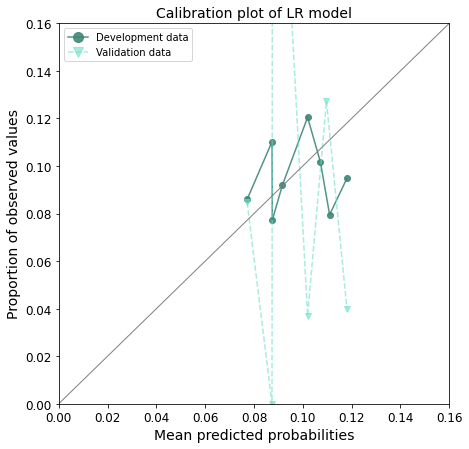

In [47]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_during_pandemic, prob_pred_urti_no_abs_prevl_during_pandemic_bin = cox_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic, data_urti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti', 'prevl_during_pandemic_deciles', prob_pred_urti_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5244 total observations, 5207 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 5244
number of events observed = 37
   partial log-likelihood = -294.15
         time fit was run = 2023-08-05 08:30:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.67       1.95       0.56            -0.43             1.77                 0.65                 5.87
CCI_cat[T.medium]                0.35       1.41       0.63            -0.89             1.58                 0.41                 4.86
CCI_cat[T.high]                  0.46       1.58       0.71            -0.93             1.85                 0.39                 6.38
CCI_cat[T.very_high]             0.38       1.46       0.65            -0.90             1.66                 0.41                 5.23
age_cat[T.25_34]                -0.37       0.69       0.59            -1.52             0.79                 0.22                 2.20
age_cat[T.35_44]                -0.22       0.80       0.56            -1.32             0.87                 0.27                 2.39
age_cat[T.45_54]                -1.31       0.27       0.80            -2.88             0.27                 0.06                 1.30
age_cat[T.55_64]                 0.12       1.13       0.51            -0.87             1.11                 0.42                 3.05
age_cat[T.65_74]                -0.32       0.73       0.59            -1.47             0.83                 0.23                 2.30
age_cat[T.75_more]              -0.98       0.37       0.69            -2.34             0.37                 0.10                 1.45
antibacterial_brit              -0.01       0.99       0.12            -0.24             0.22                 0.79                 1.25
bmi_cat[T.obese]                17.98   6.41e+07    4199.56         -8213.00          8248.95                 0.00                  inf
bmi_cat[T.overweight]           17.55   4.20e+07    4199.56         -8213.42          8248.53                 0.00                  inf
bmi_cat[T.underweight]          -0.15       0.86    8548.61        -16755.11         16754.81                 0.00                  inf
bmi_cat[T.unknown]              17.97   6.39e+07    4199.56         -8213.00          8248.95                 0.00                  inf
ethnicity[T.other]               0.52       1.68       0.74            -0.92             1.96                 0.40                 7.12
ethnicity[T.unknown]            -0.53       0.59       0.71            -1.93             0.87                 0.15                 2.38
ethnicity[T.white]              -0.02       0.98       0.62            -1.24             1.19                 0.29                 3.29
flu_vaccine[T.yes]             -17.98       0.00    3811.92         -7489.21          7453.25                 0.00                  inf
imd[T.medium]                    1.26       3.52       0.80            -0.32             2.83                 0.73                16.98
imd[T.unaffluent]                1.56       4.74       0.78             0.02             3.09                 1.02                22.04
imd[T.unknown]                   2.18       8.84       0.87             0.48             3.88                 1.61                48.56
imd[T.very_affluent]             1.31       3.71       0.79            -0.24             2.86                 0.79                17.53
imd[T.very_unaffluent]           1.18       3.25       0.80            -0.40             2.75                 0.67                15.68
region[T.east_midlands]          1.00       2.71       0.84            -0

13093


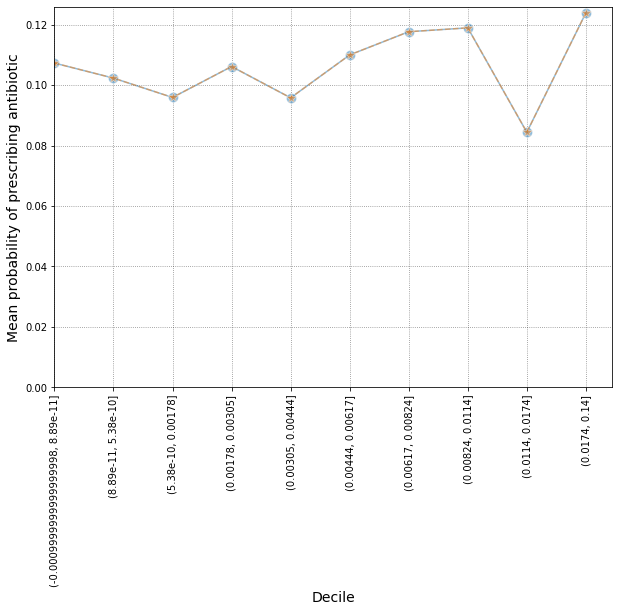


AUROC of LR for deciles with development and validation data: 0.53427 and 0.51577
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00178, 0.00305]  0.143295       -0.200255        0.486845   
1    bins_(0.00305, 0.00444] -0.078042       -0.426520        0.270435   
2    bins_(0.00444, 0.00617]  0.001837       -0.348218        0.351892   
3    bins_(0.00617, 0.00824] -0.016102       -0.383757        0.351552   
4     bins_(0.00824, 0.0114]  0.168938       -0.171473        0.509350   
5      bins_(0.0114, 0.0174] -0.141069       -0.463667        0.181529   
6        bins_(0.0174, 0.14]  0.217847       -0.110544        0.546238   
7   bins_(5.38e-10, 0.00178] -0.151418       -0.529204        0.226367   
8  bins_(8.89e-11, 5.38e-10] -0.043681       -0.386543        0.299181   

         or  or_lower_95%  or_upper_95%  
0  1.154070      0.818522      1.627175  
1  0.924925      0.652777      1.310534  
2  1.001838      0.705945      1.4217

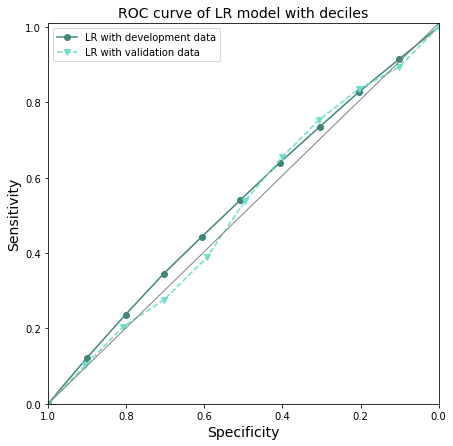

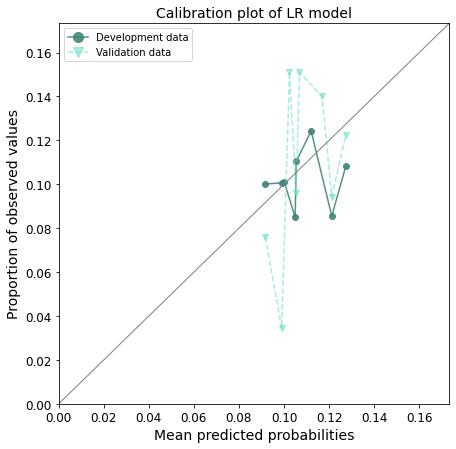

In [48]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown, data_urti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")